<h1>Galaxies, Stars and Quasars classification</h1>
The Dataset are made in this way:
<ul>
    <li>objid       = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS</li>
    <li>ra          = Right Ascension angle (at J2000 epoch)</li>
    <li>dec         = Declination angle (at J2000 epoch)</li>
    <li>u           = Ultraviolet filter in the photometric system</li>
    <li>g           = Green filter in the photometric system</li>
    <li>r           = Red filter in the photometric system</li>
    <li>i           = Near Infrared filter in the photometric system</li>
    <li>z           = Infrared filter in the photometric system</li>
    <li>run         = Run Number used to identify the specific scan</li>
    <li>rereun      = Rerun Number to specify how the image was processed</li>
    <li>camcol      = Camera column to identify the scanline within the run</li>
    <li>field       = Field number to identify each field</li>
    <li>specobjid   = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)</li>
    <li>redshift    = redshift value based on the increase in wavelength</li>
    <li>plate       = plate ID, identifies each plate in SDSS</li>
    <li>mjd         = Modified Julian Date, used to indicate when a given piece of SDSS data was taken</li>
    <li>fiberid     = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation</li>
    <li>class       = object class (galaxy, star or quasar object)</li>
</ul>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, f1_score, make_scorer

import pickle

import warnings
warnings.filterwarnings("ignore")


Let's start loading the dataset in a dataframe

In [2]:
# dfStars = pd.read_csv('Skyserver_12_15_2020 3 45 07 AM.csv', na_values="?")
dfStars = pd.read_csv('FileCSV/star_classification.csv', na_values="?")
dfStars

objid          ra        dec         u         g         r  \
0      1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1      1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2      1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3      1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4      1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   
...             ...         ...        ...       ...       ...       ...   
99995  1.237679e+18   39.620709  -2.594074  22.16759  22.97586  21.90404   
99996  1.237679e+18   29.493819  19.798874  22.69118  22.38628  20.45003   
99997  1.237668e+18  224.587407  15.700707  21.16916  19.26997  18.20428   
99998  1.237661e+18  212.268621  46.660365  25.35039  21.63757  19.91386   
99999  1.237661e+18  196.896053  49.464643  22.62171  21.79745  20.60115   

              i         z   run  rerun  camcol  field     specobjid   class  \
0      19.16573  18.79371  3606    301       2     79  6.543777e+18  GALAXY   
1      21.16812  21.61427  4518    301       5    119  1.176014e+19  GALAXY   
2      19.34857  18.94827  3606    301       2    120  5.152200e+18  GALAXY   
3      20.50454  19.25010  4192    301       3    214  1.030107e+19  GALAXY   
4      15.97711  15.54461  8102    301       3    137  6.891865e+18  GALAXY   
...         ...       ...   ...    ...     ...    ...           ...     ...   
99995  21.30548  20.73569  7778    301       2    581  1.055431e+19  GALAXY   
99996  19.75759  19.41526  7917    301       1    289  8.586351e+18  GALAXY   
99997  17.69034  17.35221  5314    301       4    308  3.112008e+18  GALAXY   
99998  19.07254  18.62482  3650    301       4    131  7.601080e+18  GALAXY   
99999  20.00959  19.28075  3650    301       4     60  8.343152e+18  GALAXY   

       redshift  plate    mjd  fiberid  
0      0.634794   5812  56354      171  
1      0.779136  10445  58158      427  
2      0.644195   4576  55592      299  
3      0.932346   9149  58039      775  
4      0.116123   6121  56187      842  
...         ...    ...    ...      ...  
99995  0.000000   9374  57749      438  
99996  0.404895   7626  56934      866  
99997  0.143366   2764  54535       74  
99998  0.455040   6751  56368      470  
99999  0.542944   7410  57104      851  

[100000 rows x 18 columns]

In [4]:
dfStars.head().T

0                       1  \
objid      1237660961327743232.0   1237664879951151104.0   
ra                    135.689107              144.826101   
dec                    32.494632               31.274185   
u                       23.87882                24.77759   
g                        22.2753                22.83188   
r                       20.39501                22.58444   
i                       19.16573                21.16812   
z                       18.79371                21.61427   
run                         3606                    4518   
rerun                        301                     301   
camcol                         2                       5   
field                         79                     119   
specobjid  6543777369295181824.0  11760142036707334144.0   
class                     GALAXY                  GALAXY   
redshift                0.634794                0.779136   
plate                       5812                   10445   
mjd                        56354                   58158   
fiberid                      171                     427   

                               2                       3  \
objid      1237660961330430208.0   1237663478724297984.0   
ra                     142.18879              338.741038   
dec                    35.582444               -0.402828   
u                       25.26307                22.13682   
g                       22.66389                23.77656   
r                       20.60976                21.61162   
i                       19.34857                20.50454   
z                       18.94827                 19.2501   
run                         3606                    4192   
rerun                        301                     301   
camcol                         2                       3   
field                        120                     214   
specobjid  5152200256025548800.0  10301071412954419200.0   
class                     GALAXY                  GALAXY   
redshift                0.644195                0.932346   
plate                       4576                    9149   
mjd                        55592                   58039   
fiberid                      299                     775   

                               4  
objid      1237680272041378048.0  
ra                    345.282593  
dec                    21.183866  
u                       19.43718  
g                       17.58028  
r                       16.49747  
i                       15.97711  
z                       15.54461  
run                         8102  
rerun                        301  
camcol                         3  
field                        137  
specobjid  6891864880783316992.0  
class                     GALAXY  
redshift                0.116123  
plate                       6121  
mjd                        56187  
fiberid                      842

Check same info about the feature of the DataSet

In [5]:
dfStars.drop('class', axis=1).describe()

objid             ra            dec              u  \
count  1.000000e+05  100000.000000  100000.000000  100000.000000   
mean   1.237665e+18     177.629117      24.135305      21.980468   
std    8.438560e+12      96.502241      19.644665      31.769291   
min    1.237646e+18       0.005528     -18.785328   -9999.000000   
25%    1.237659e+18     127.518222       5.146771      20.352353   
50%    1.237663e+18     180.900700      23.645922      22.179135   
75%    1.237668e+18     233.895005      39.901550      23.687440   
max    1.237681e+18     359.999810      83.000519      32.781390   

                   g              r              i              z  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       20.531387      19.645762      19.084854      18.668810   
std        31.750292       1.854760       1.757895      31.728152   
min     -9999.000000       9.822070       9.469903   -9999.000000   
25%        18.965230      18.135828      17.732285      17.460677   
50%        21.099835      20.125290      19.405145      19.004595   
75%        22.123767      21.044785      20.396495      19.921120   
max        31.602240      29.571860      32.141470      29.383740   

                 run     rerun         camcol          field     specobjid  \
count  100000.000000  100000.0  100000.000000  100000.000000  1.000000e+05   
mean     4481.366060     301.0       3.511610     186.130520  5.783882e+18   
std      1964.764593       0.0       1.586912     149.011073  3.324016e+18   
min       109.000000     301.0       1.000000      11.000000  2.995191e+17   
25%      3187.000000     301.0       2.000000      82.000000  2.844138e+18   
50%      4188.000000     301.0       4.000000     146.000000  5.614883e+18   
75%      5326.000000     301.0       5.000000     241.000000  8.332144e+18   
max      8162.000000     301.0       6.000000     989.000000  1.412694e+19   

            redshift          plate            mjd        fiberid  
count  100000.000000  100000.000000  100000.000000  100000.000000  
mean        0.576661    5137.009660   55588.647500     449.312740  
std         0.730707    2952.303351    1808.484233     272.498404  
min        -0.009971     266.000000   51608.000000       1.000000  
25%         0.054517    2526.000000   54234.000000     221.000000  
50%         0.424173    4987.000000   55868.500000     433.000000  
75%         0.704154    7400.250000   56777.000000     645.000000  
max         7.011245   12547.000000   58932.000000    1000.000000

In [6]:
dfStars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   objid      100000 non-null  float64
 1   ra         100000 non-null  float64
 2   dec        100000 non-null  float64
 3   u          100000 non-null  float64
 4   g          100000 non-null  float64
 5   r          100000 non-null  float64
 6   i          100000 non-null  float64
 7   z          100000 non-null  float64
 8   run        100000 non-null  int64  
 9   rerun      100000 non-null  int64  
 10  camcol     100000 non-null  int64  
 11  field      100000 non-null  int64  
 12  specobjid  100000 non-null  float64
 13  class      100000 non-null  object 
 14  redshift   100000 non-null  float64
 15  plate      100000 non-null  int64  
 16  mjd        100000 non-null  int64  
 17  fiberid    100000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 13.7+ MB


Check for Nan or Null value, but how we can see this datasets have no Null or Nan value.

In [7]:
dfStars.isna().sum(axis=0)

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

Checking if there is some duplicate, but how we can see this datasets have no duplicate.

In [8]:
dfStars[dfStars['objid'].duplicated(keep=False)]

objid          ra        dec         u         g         r  \
7      1.237679e+18    5.433176  12.065186  22.24979  22.02172  20.34126   
16     1.237679e+18  353.201522   3.080796  24.54890  21.44267  20.95315   
17     1.237679e+18    1.494389   3.291746  20.38562  20.40514  20.29996   
19     1.237652e+18  167.131669  67.339936  20.48292  18.67807  17.61680   
21     1.237658e+18  144.785293  46.826496  24.54793  22.33601  20.92259   
...             ...         ...        ...       ...       ...       ...   
99977  1.237661e+18  217.958430  52.316738  24.15617  22.05986  21.80826   
99981  1.237661e+18  216.867480  42.516998  19.70111  18.42188  17.74521   
99982  1.237667e+18  142.794105  22.754891  22.40577  21.63441  20.60844   
99984  1.237661e+18  217.316578  42.325055  25.36042  22.32818  20.52005   
99994  1.237663e+18  317.246996  -0.682254  20.96526  19.81625  19.34186   

              i         z   run  rerun  camcol  field     specobjid   class  \
7      19.48794  18.84999  7773    301       2    346  6.961443e+18  GALAXY   
16     20.79360  20.48442  7712    301       5    284  4.822278e+18    STAR   
17     20.05918  19.89044  7712    301       5    339  9.843824e+18     QSO   
19     17.11936  16.73351  1412    301       5    124  5.518595e+17  GALAXY   
21     19.87177  19.16934  2821    301       2     28  8.237292e+18    STAR   
...         ...       ...   ...    ...     ...    ...           ...     ...   
99977  21.95129  21.24179  3705    301       2    124  7.916218e+18     QSO   
99981  17.38254  17.14679  3699    301       3    174  1.570675e+18  GALAXY   
99982  19.74394  19.54434  5061    301       3    194  6.517949e+18  GALAXY   
99984  19.41139  18.88105  3699    301       3    177  6.823167e+18  GALAXY   
99994  19.14711  19.05790  4187    301       2     64  1.154061e+18  GALAXY   

       redshift  plate    mjd  fiberid  
7      0.477009   6183  56210       15  
16    -0.000429   4283  55864      178  
17     2.031528   8743  57663      295  
19     0.111588    490  51929      613  
21    -0.000120   7316  56710      756  
...         ...    ...    ...      ...  
99977  1.067543   7031  56449       58  
99981  0.130918   1395  52825      161  
99982  0.498444   5789  56246      417  
99984  0.548908   6060  56074      777  
99994  0.175206   1025  53239       51  

[37306 rows x 18 columns]

In [9]:
dfStars[dfStars.duplicated(keep=False)]

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, rerun, camcol, field, specobjid, class, redshift, plate, mjd, fiberid]
Index: []

In the following heatmap we can see the correlation between the most important feature of the datasets. We can see that the (u, g) and (r, i)feature pair have a very high correlation, this is because of same ouliers inside the datasets.

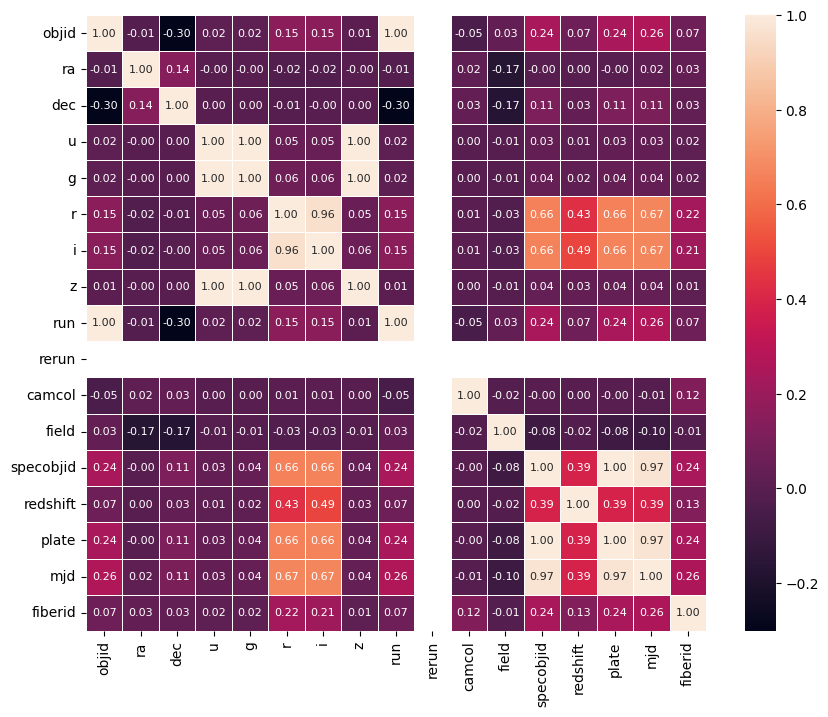

In [10]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dfStars.drop(['class'], axis = 1).corr(), annot=True, linewidths=.5, fmt='.2f', ax=ax, annot_kws={'fontsize': 8})
plt.show()

Show the relationship between all pairs of relevant variables into the dataset, considering the labeled-classes

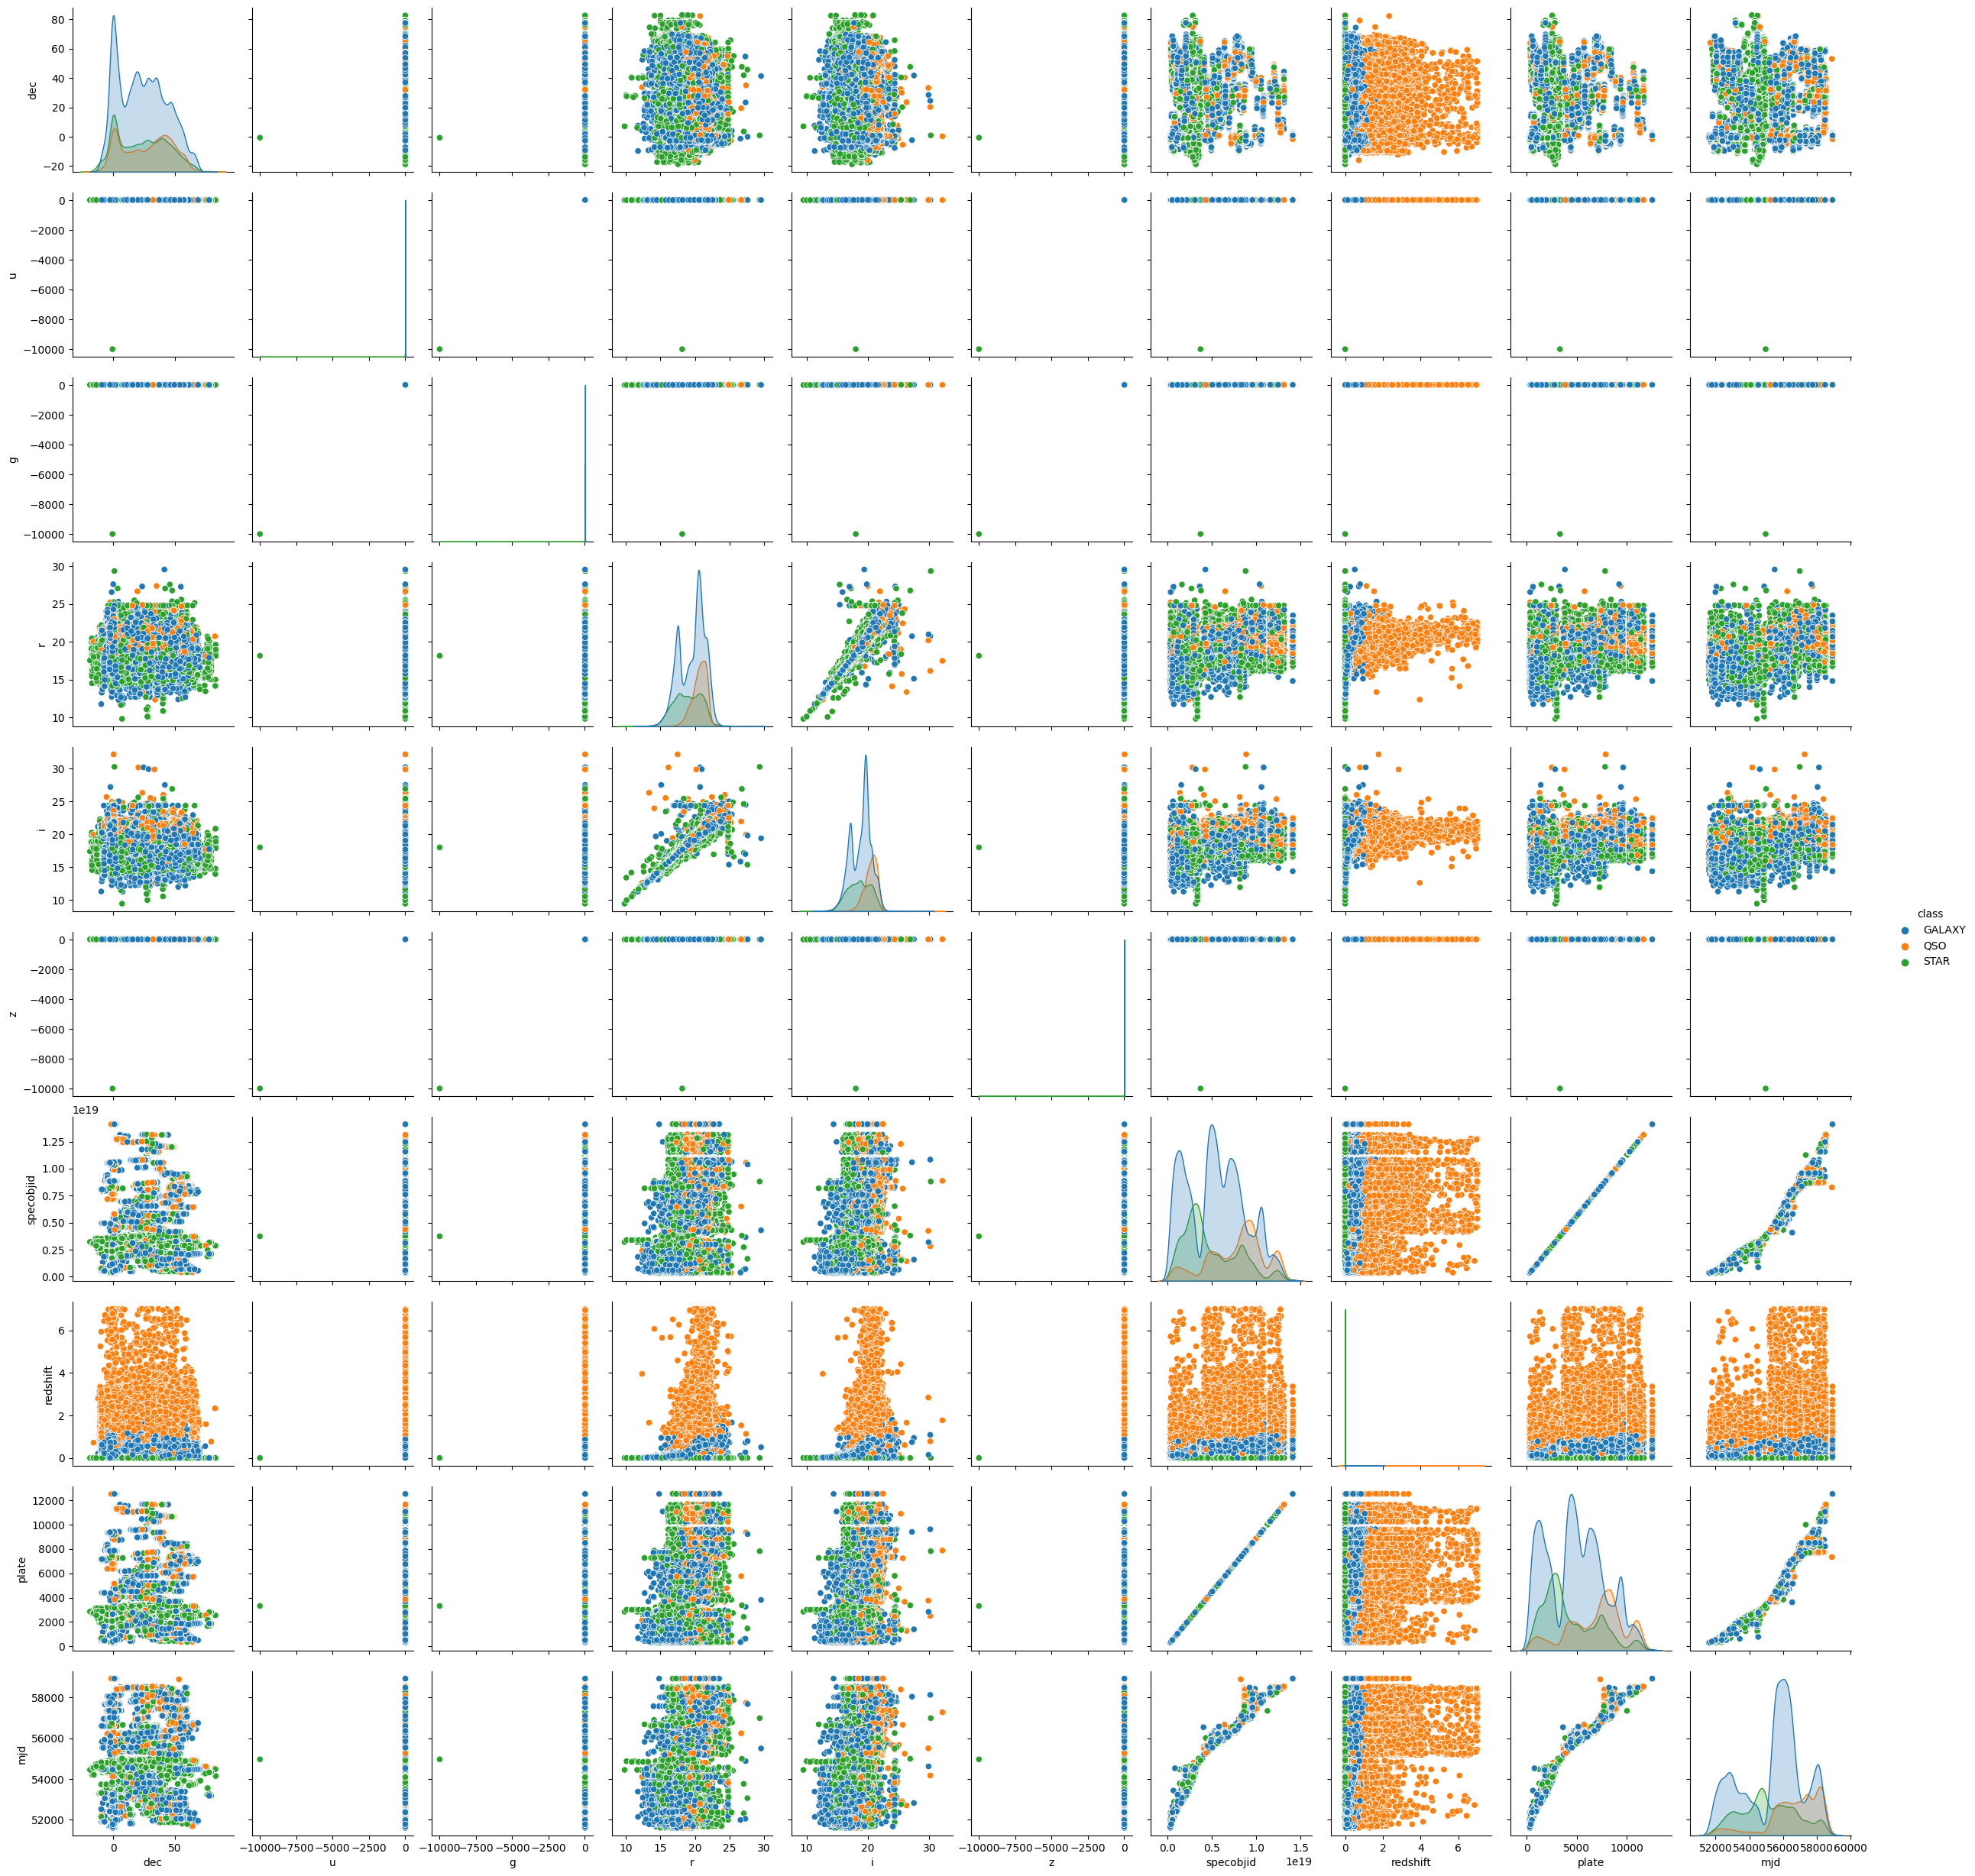

In [11]:
sns.pairplot(data=dfStars.drop(['objid', 'ra', 'run','rerun','camcol','field','fiberid'], axis = 1), hue="class")

In [12]:
dfStars.keys()

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')

<h3>Distribution of each useful attribute divided by class</h3>
This distribution will be useful for make a comparison with the dataset after the rebalance part

Here I check the distribution of the Labeled-Class

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64


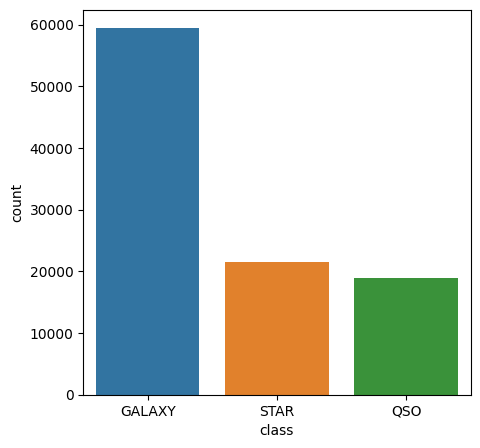

In [13]:
print(dfStars['class'].value_counts())
fig,axes = plt.subplots(1, 1, figsize=(5,5), sharey=True)
sns.countplot(x='class',data = dfStars, ax = axes, order = dfStars['class'].value_counts().index)
plt.show()

How we can see, this datasets is not well distributed. <br>
The class "Galaxy" have more than the double of the istances in compere to the other two classes. I will need to perform the rebalancing of the datasets, but not immediatly. First I'll do the split in Traing and Test set, second the Outlier Detection, and then the Rebalancing.

# Attributes Distribution
In the following steps, I see the distribution of each attribute, considering the separetion of each labeled-class. <br>
This is useful for understend the difference between each feature and what kind of attribute are more relevante for the aim of classification.

In [58]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dfStars["class"] = le.fit_transform(dfStars["class"])
dfStars["class"] = dfStars["class"].astype(int)

def plot(column):
    for i in ['GALAXY', 'STAR', 'QSO']:
        sns.kdeplot(data=dfStars[dfStars["class"] == i][column], label = le.inverse_transform([i]))
    sns.kdeplot(data=dfStars[column],label = ["All"])
    plt.legend()

def log_plot(column):
    for i in ['GALAXY', 'STAR', 'QSO']:
        sns.kdeplot(data=np.log(dfStars[dfStars["class"] == i][column]), label = le.inverse_transform([i]))
    sns.kdeplot(data=np.log(dfStars[column]),label = ["All"])
    plt.legend()

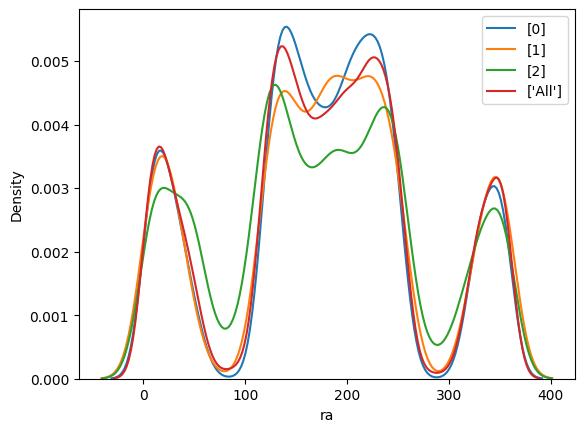

In [40]:
plot('ra')

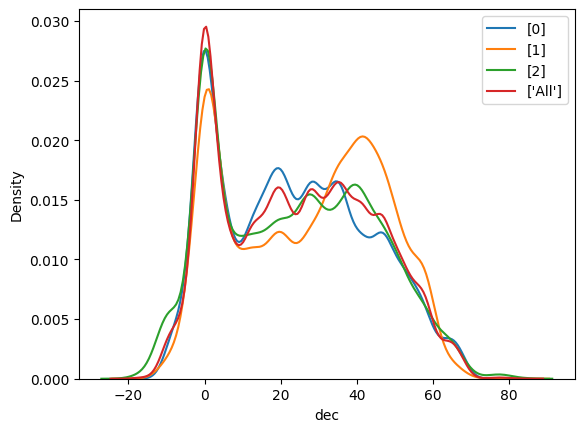

In [41]:
plot('dec')

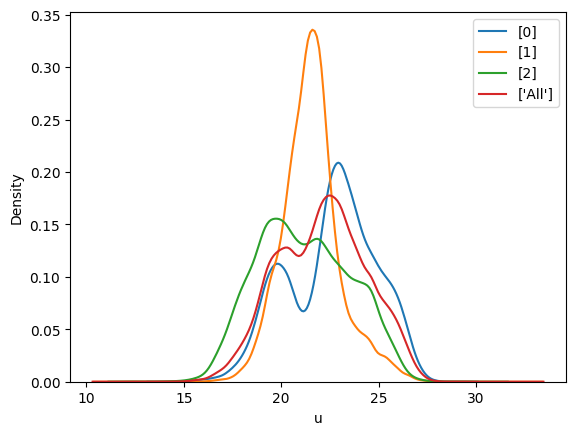

In [42]:
plot('u')

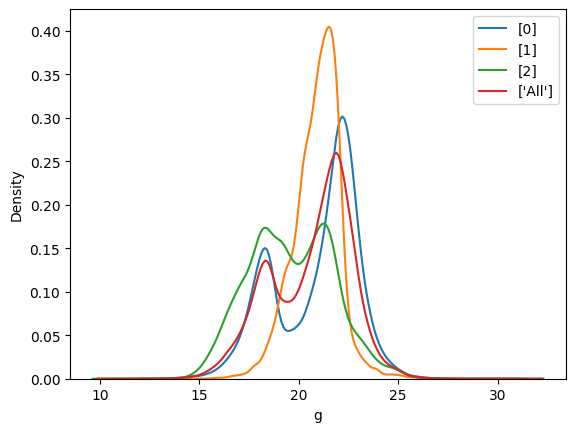

In [43]:
plot('g')

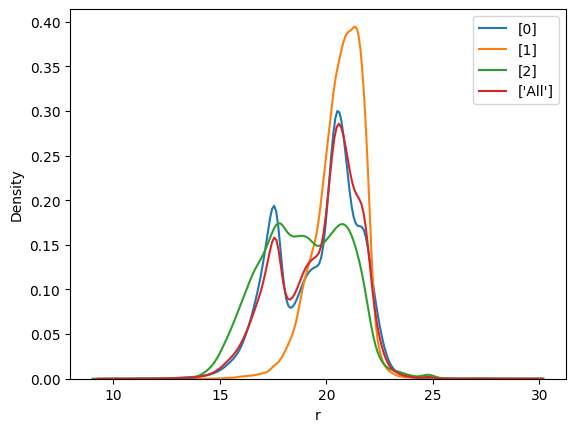

In [44]:
plot('r')

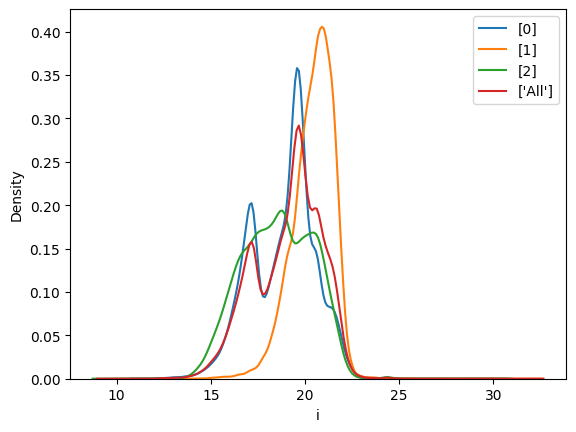

In [45]:
plot('i')

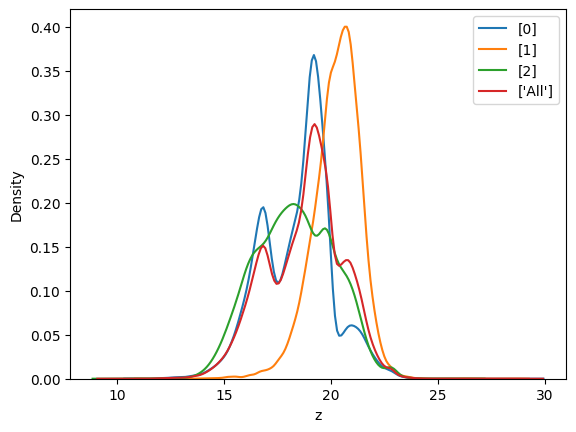

In [46]:
plot('z')

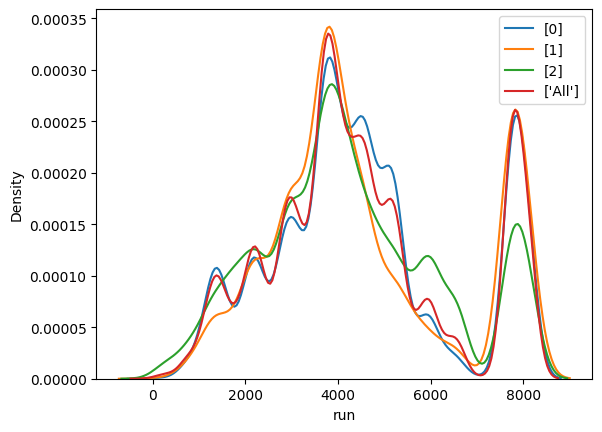

In [79]:
plot('run')

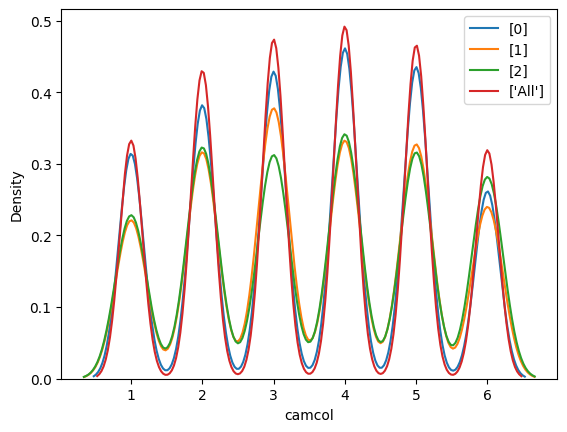

In [50]:
plot('camcol')

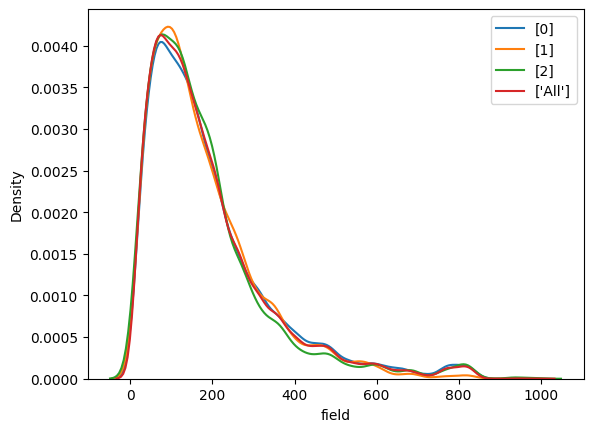

In [51]:
plot('field')

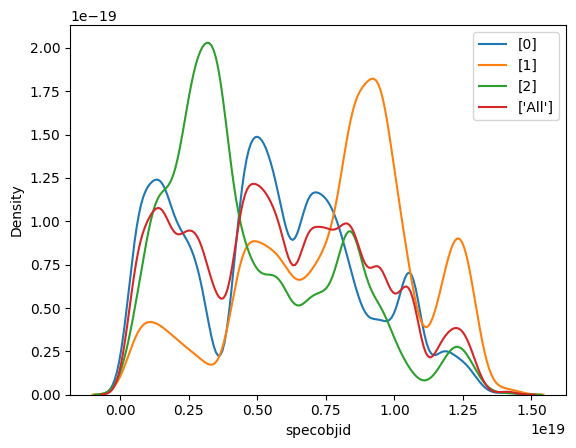

In [52]:
plot('specobjid')

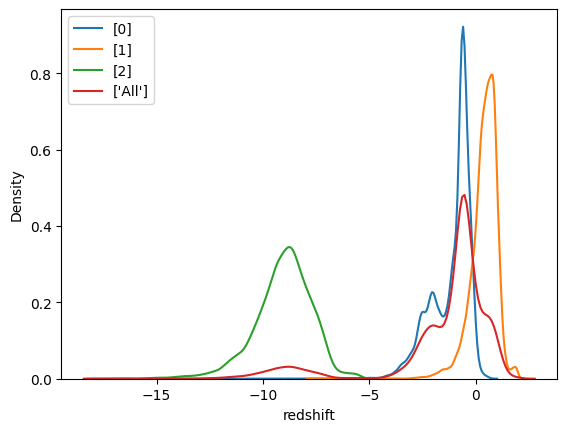

In [60]:
log_plot('redshift')

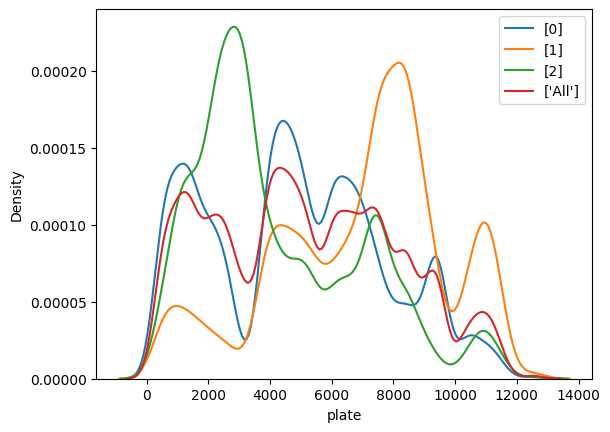

In [54]:
plot('plate')

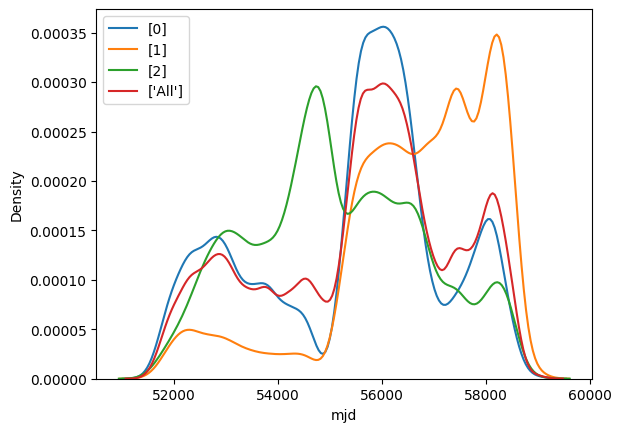

In [55]:
plot('mjd')

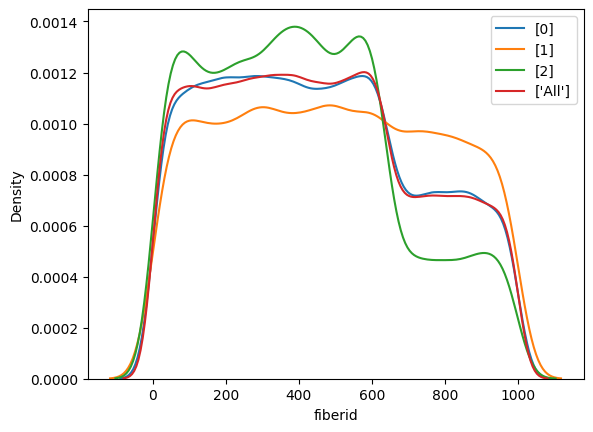

In [56]:
plot('fiberid')

# Noise 

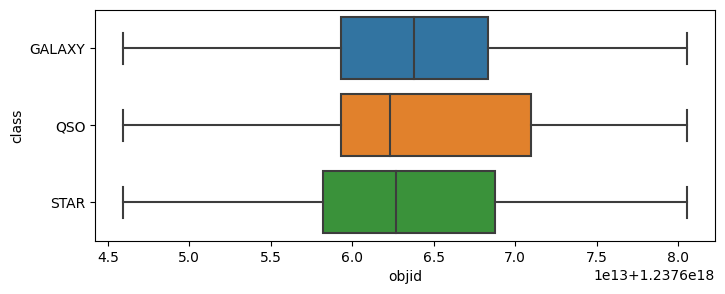

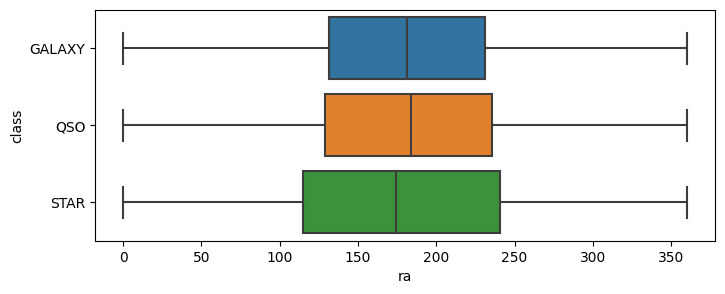

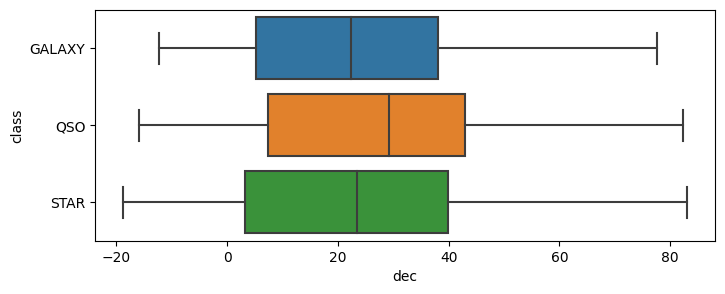

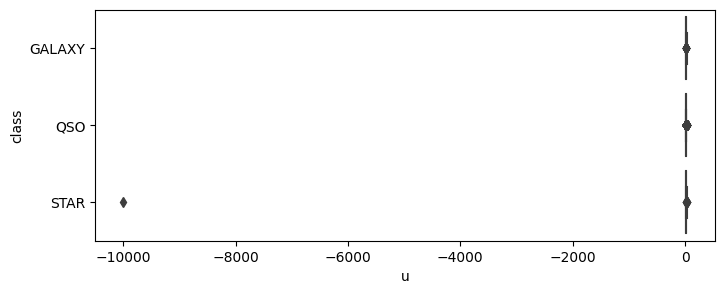

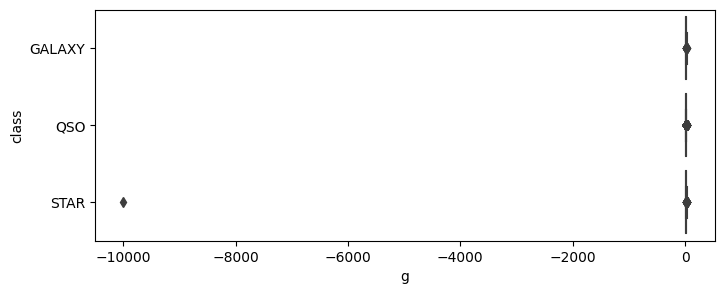

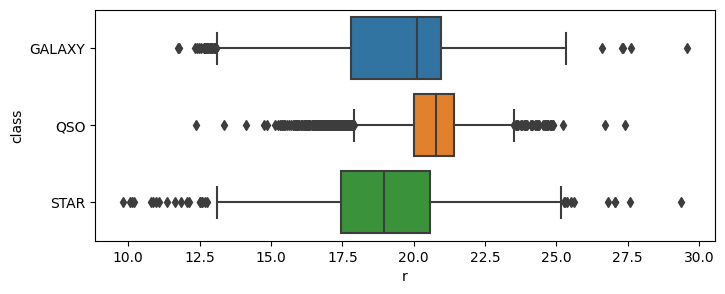

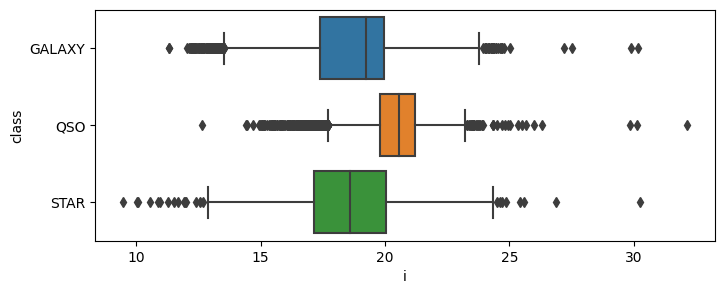

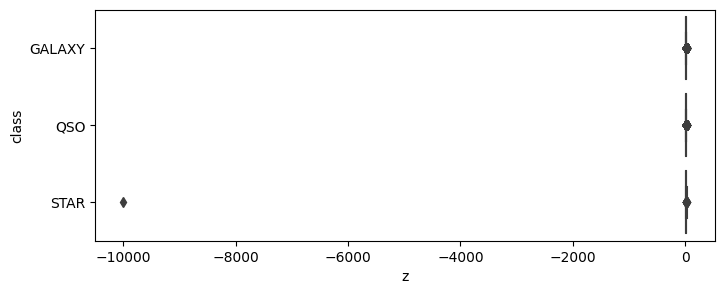

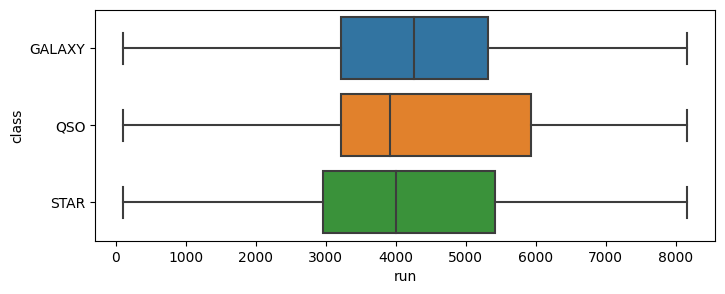

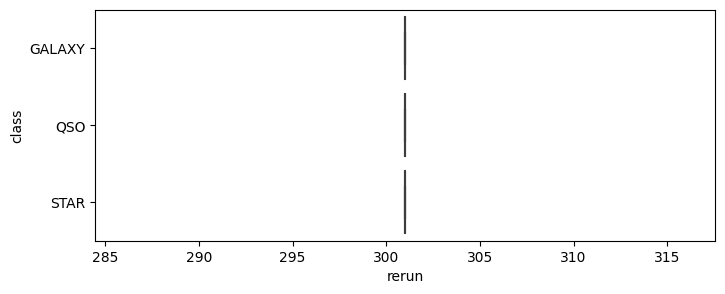

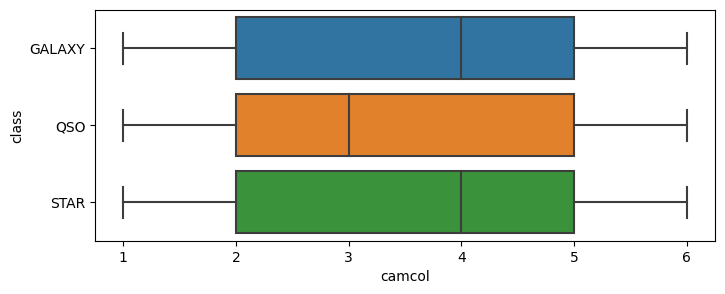

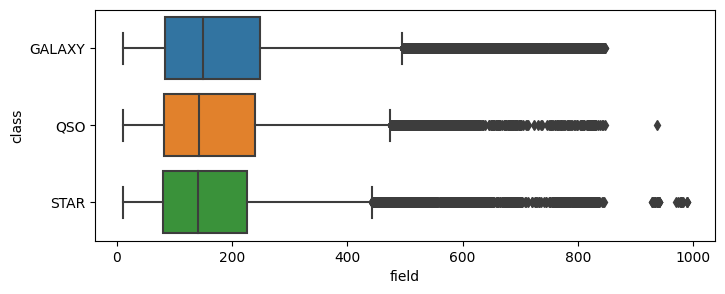

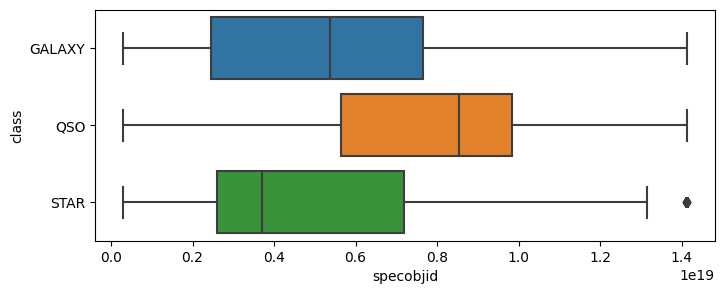

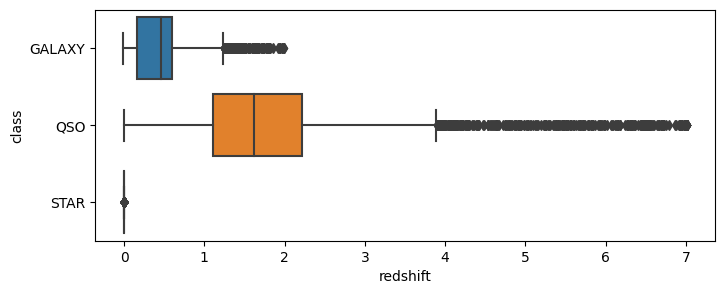

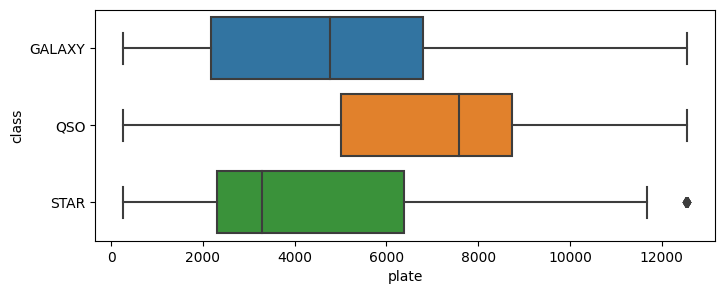

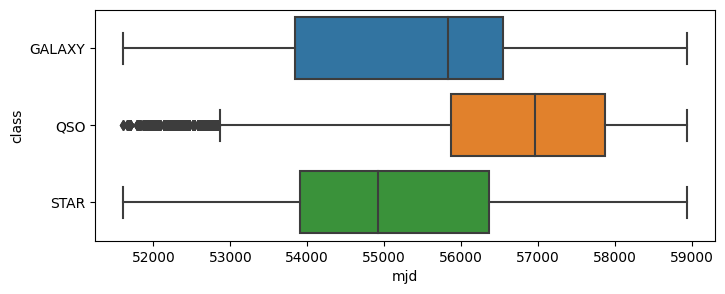

In [3]:
for att in dfStars.drop(['class'], axis=1).columns[:-1]:
    plt.figure(figsize=(8, 3))
    sns.boxplot(x=dfStars[att], y=dfStars['class'])
    plt.show()

We can see that the three attribute 'u', 'g' and 'z' have some noise inside, for the class 'STAR'. Considering that it's just one value, I decide to modify the values for this kind of noise with the mean values inside the labeled-class. 

In [3]:
dfStars[dfStars['u'] < 0]

objid          ra       dec       u       g        r         i  \
79543  1.237649e+18  224.006526 -0.624304 -9999.0 -9999.0  18.1656  18.01675   

            z  run  rerun  camcol  field     specobjid class  redshift  plate  \
79543 -9999.0  752    301       2    537  3.731277e+18  STAR  0.000089   3314   

         mjd  fiberid  
79543  54970      162

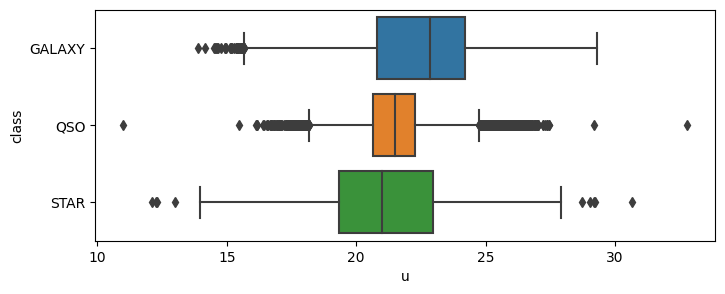

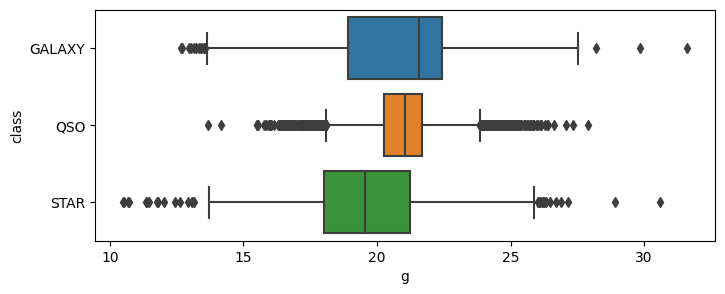

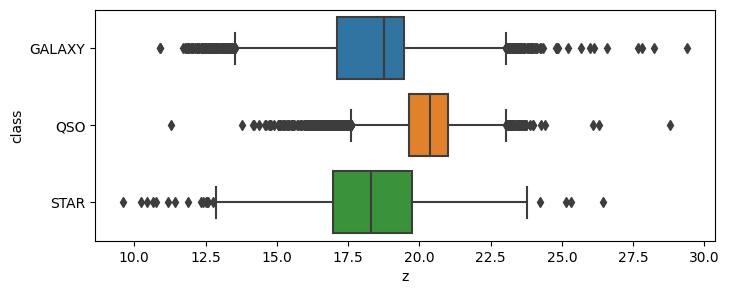

In [4]:
dfStars = dfStars.drop(labels=[79543], axis=0)

for att in ['u', 'g', 'z']:
    plt.figure(figsize=(8, 3))
    sns.boxplot(x=dfStars[att], y=dfStars['class'])
    plt.show()

In [17]:
dfStars.to_csv('FileCSV/star_classification_nonoise.csv', index=False)
dfStars = pd.read_csv('FileCSV/star_classification_nonoise.csv', na_values="?")
dfStars.drop(['Unnamed: 0'], axis=1, inplace=True)

In [18]:
dfStars.shape

(99999, 18)

Unnamed: 0


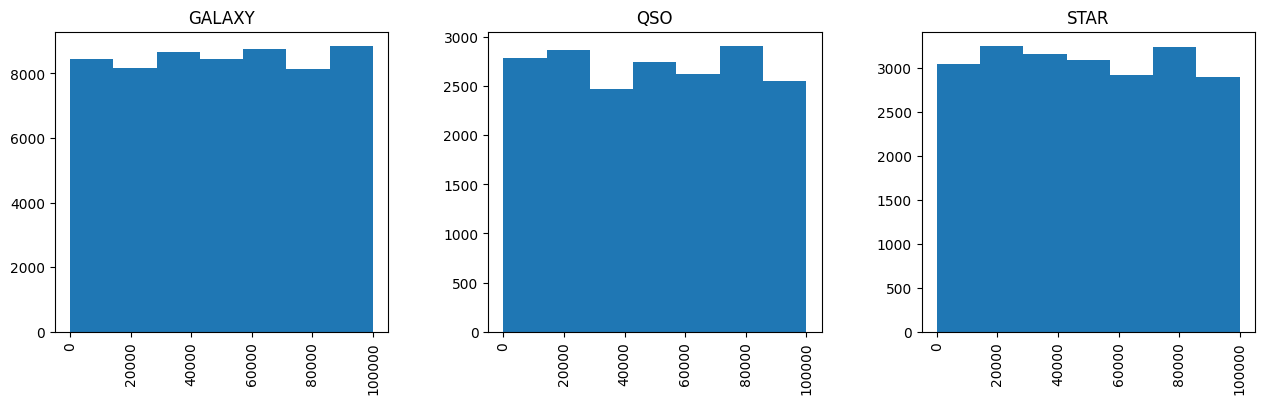

objid


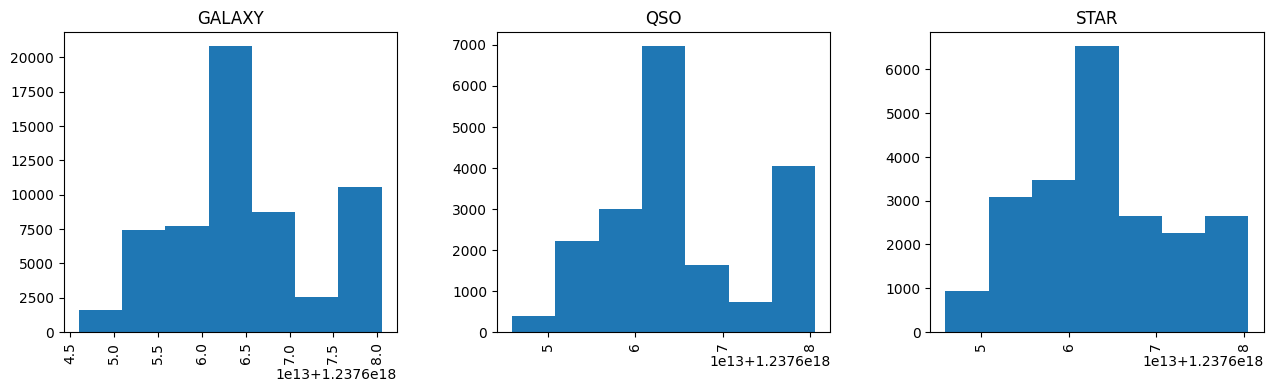

ra


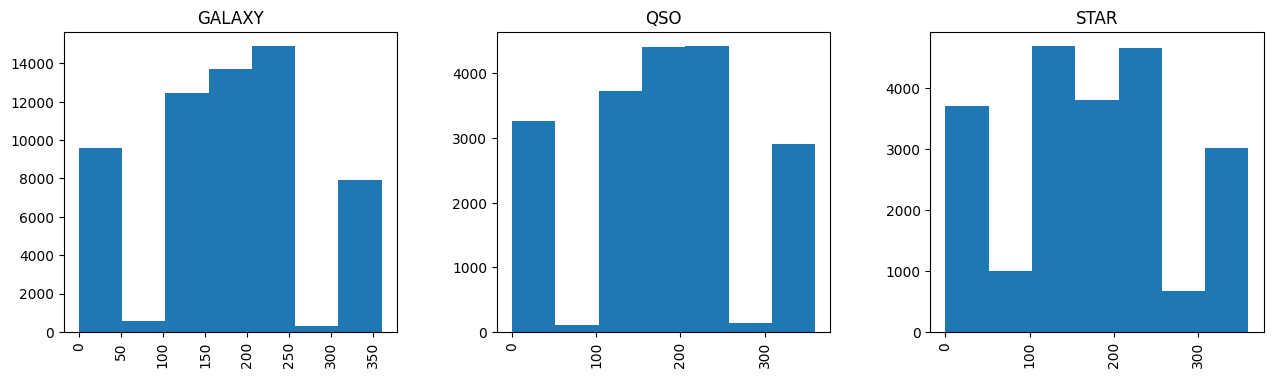

dec


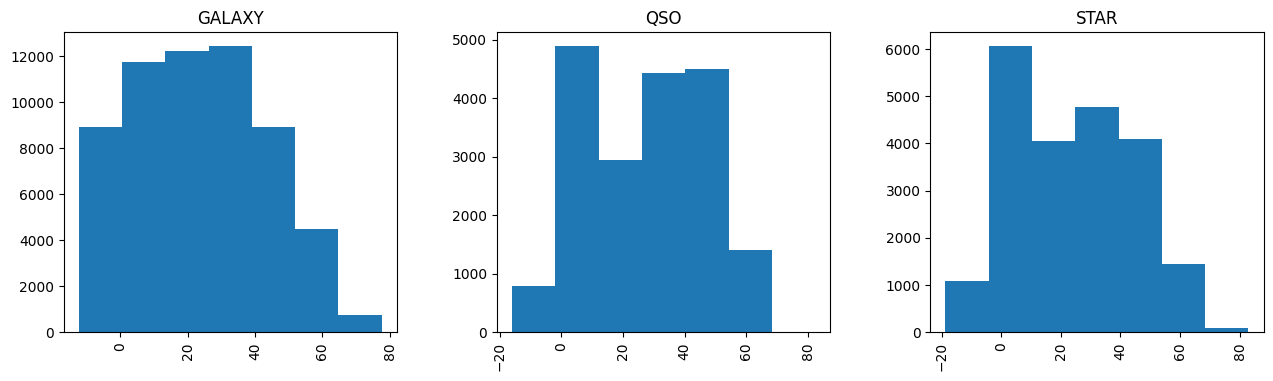

u


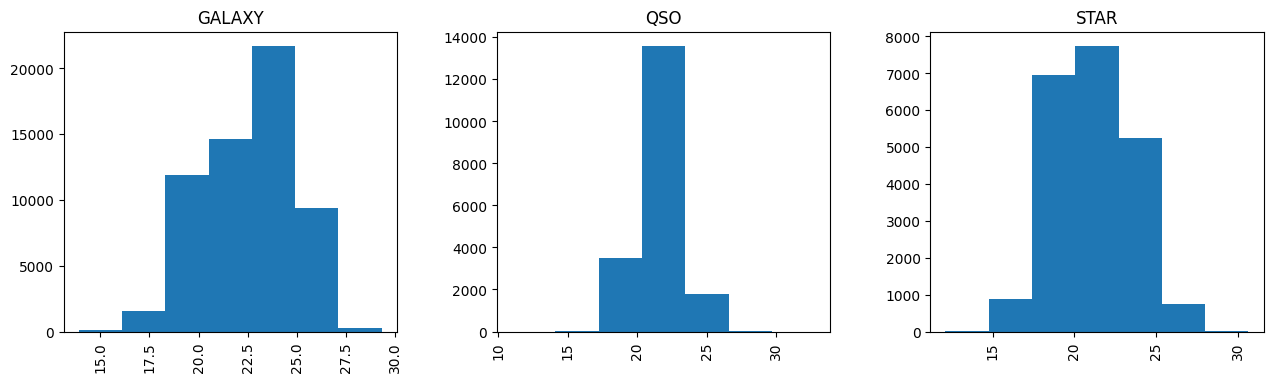

g


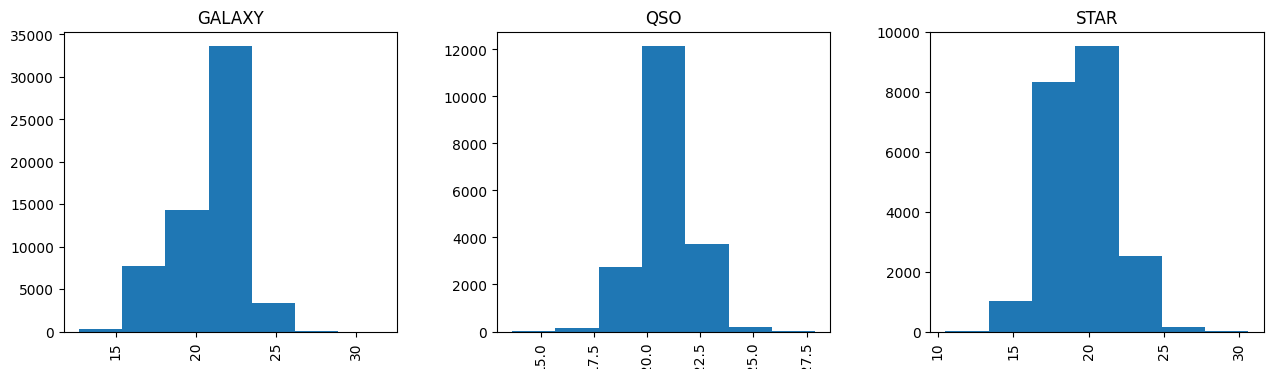

r


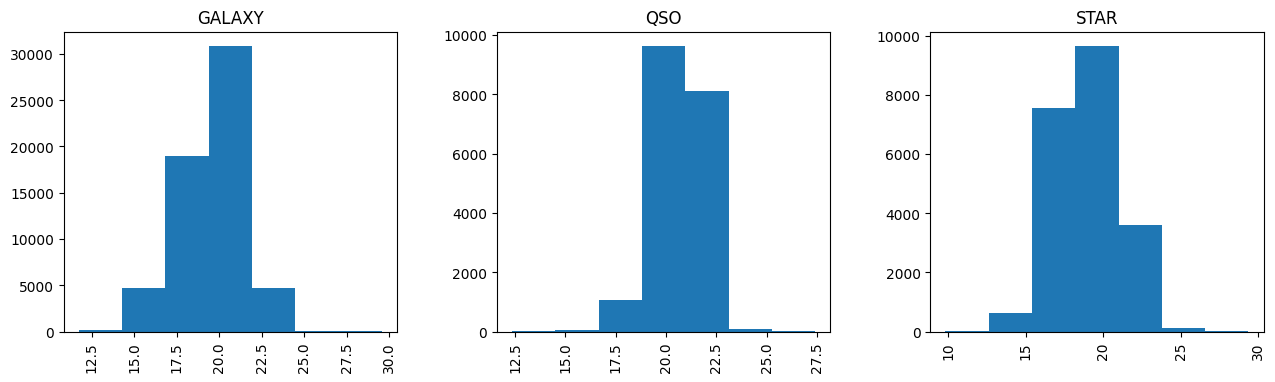

i


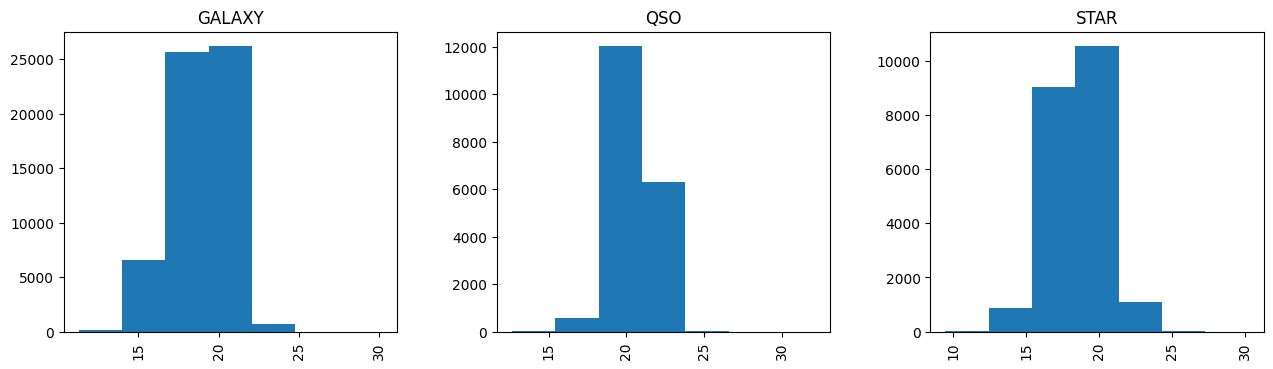

z


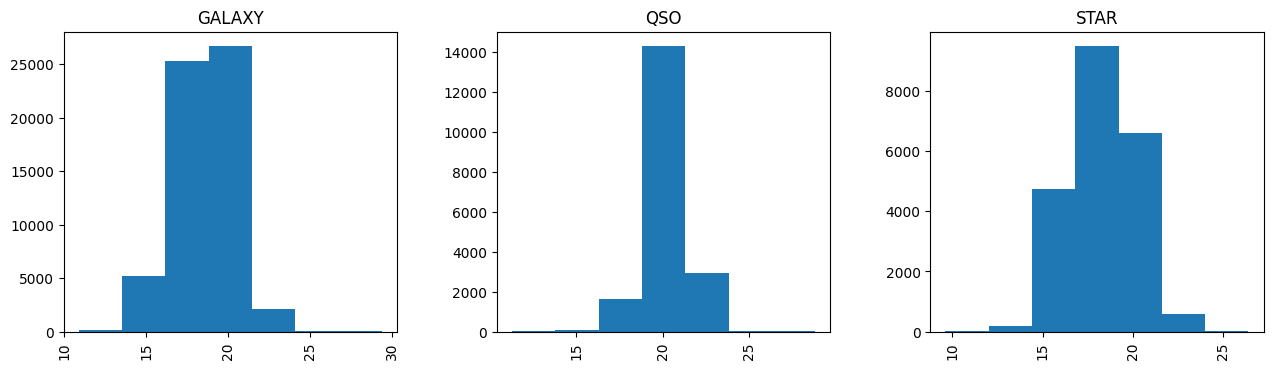

run


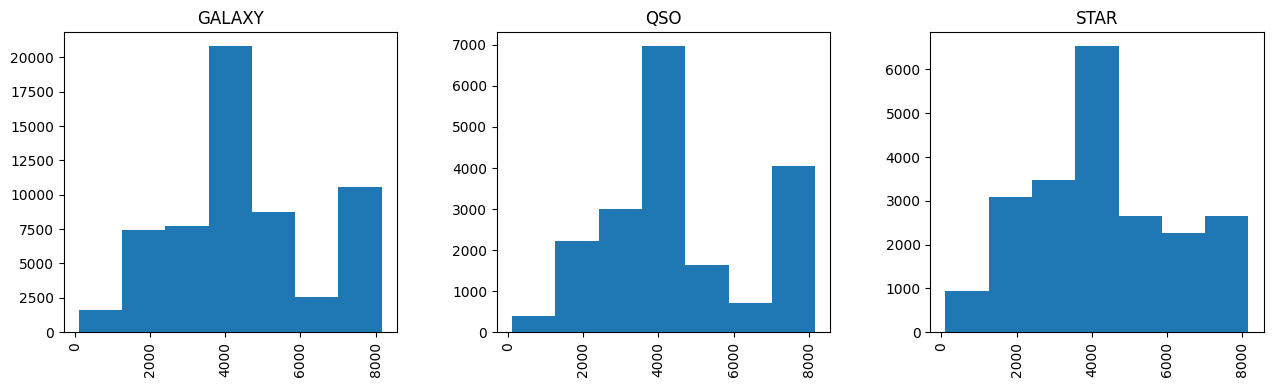

rerun


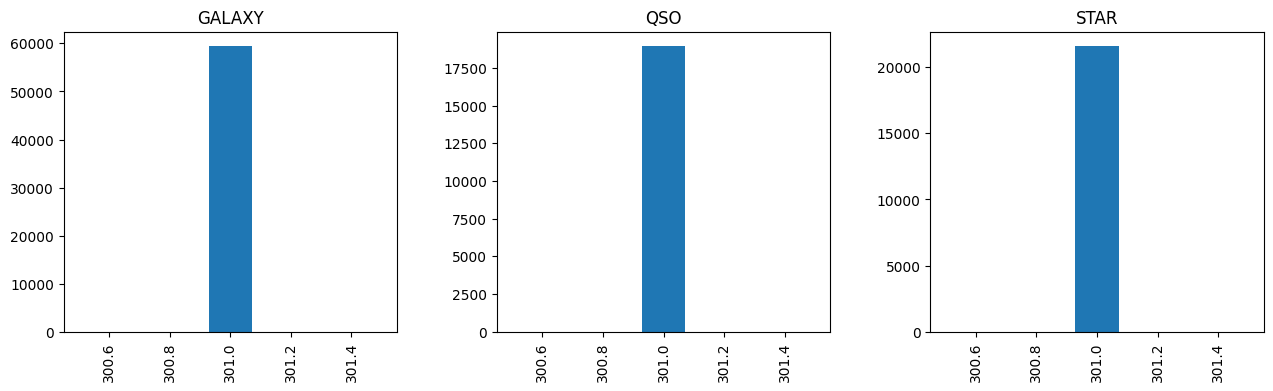

camcol


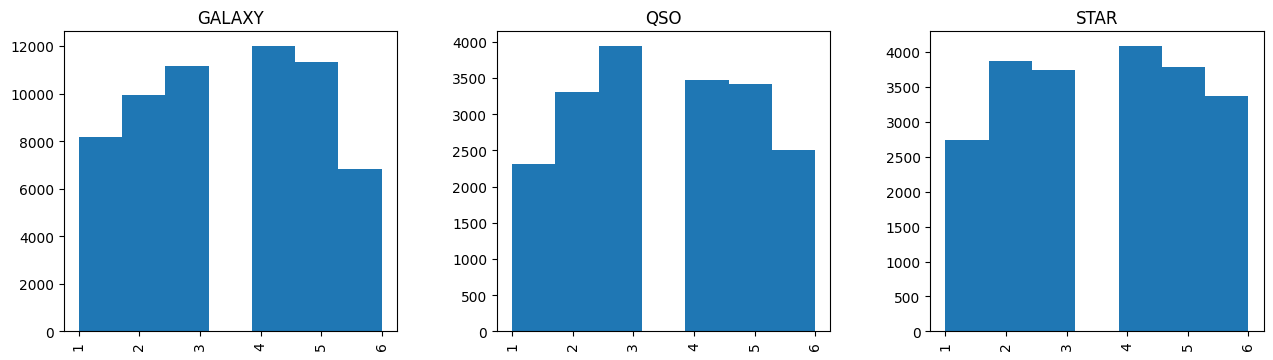

field


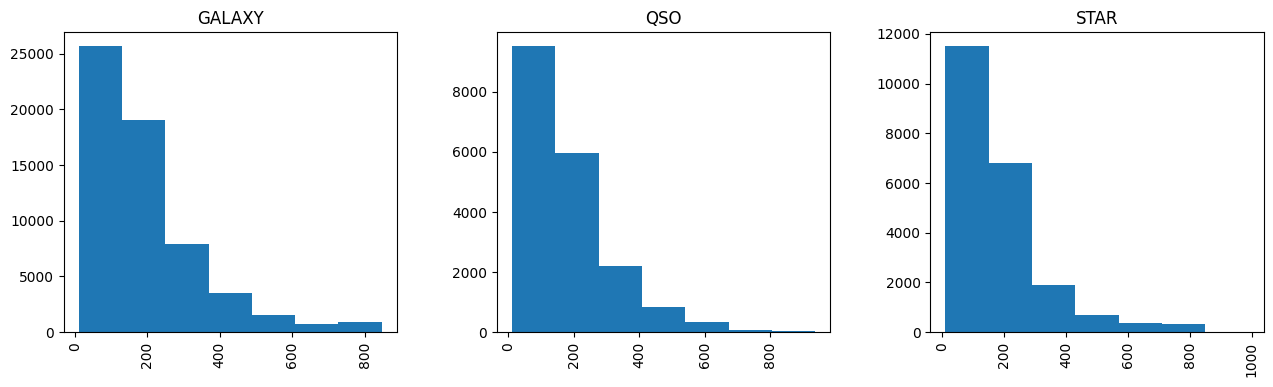

specobjid


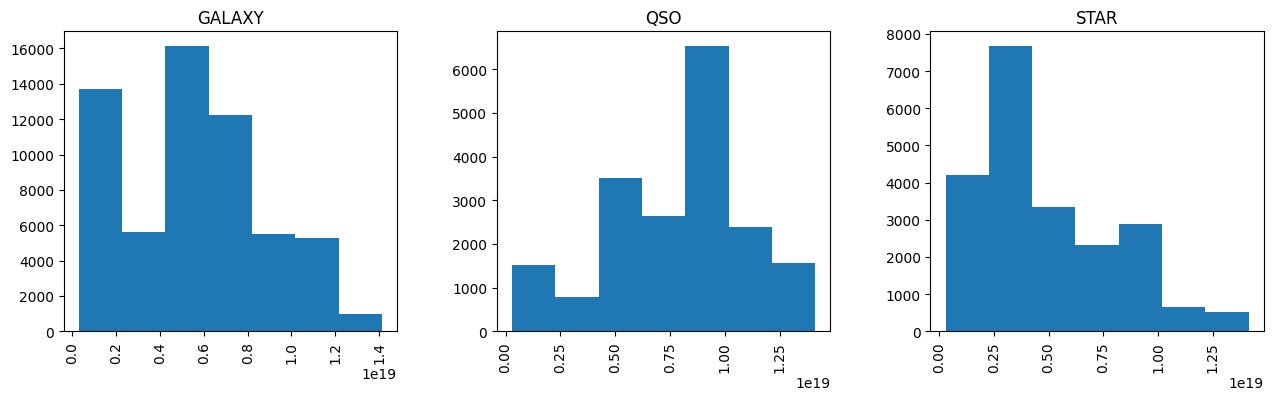

class


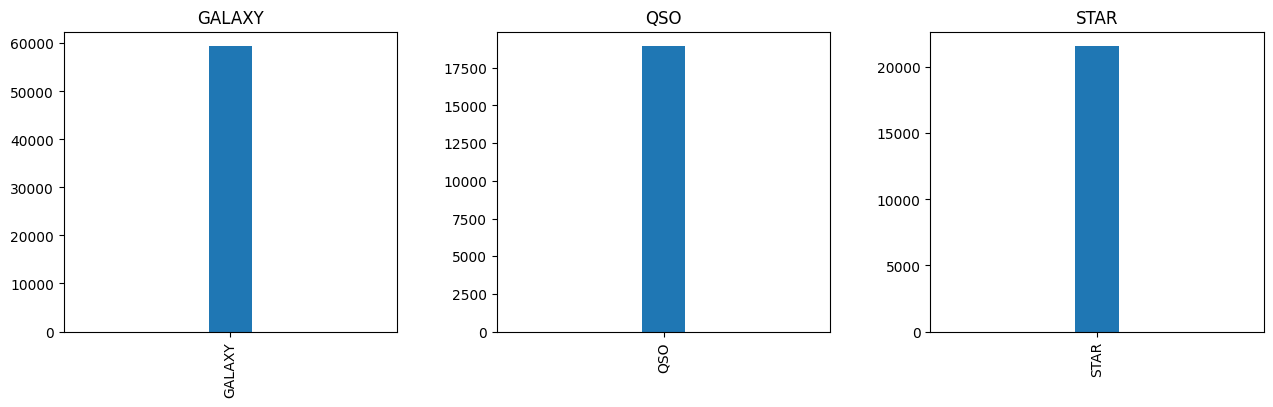

redshift


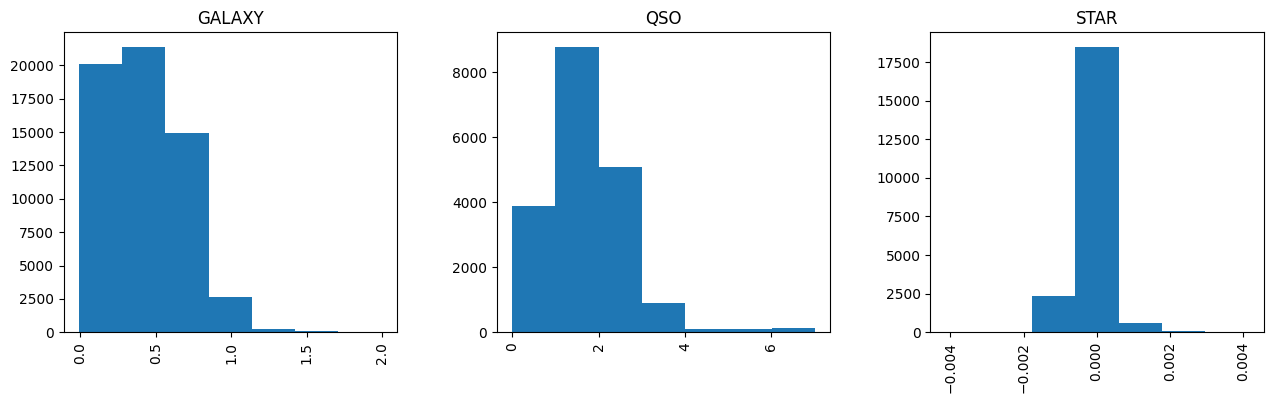

plate


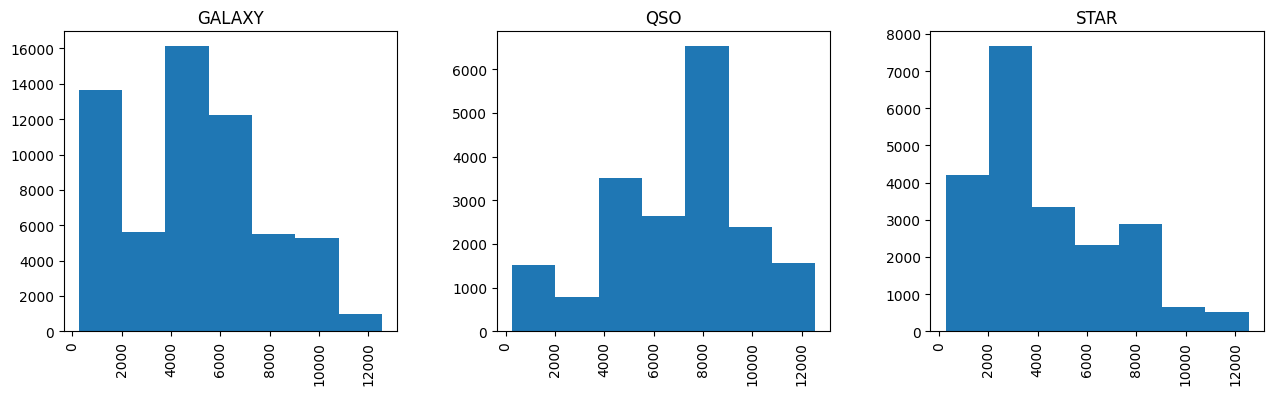

mjd


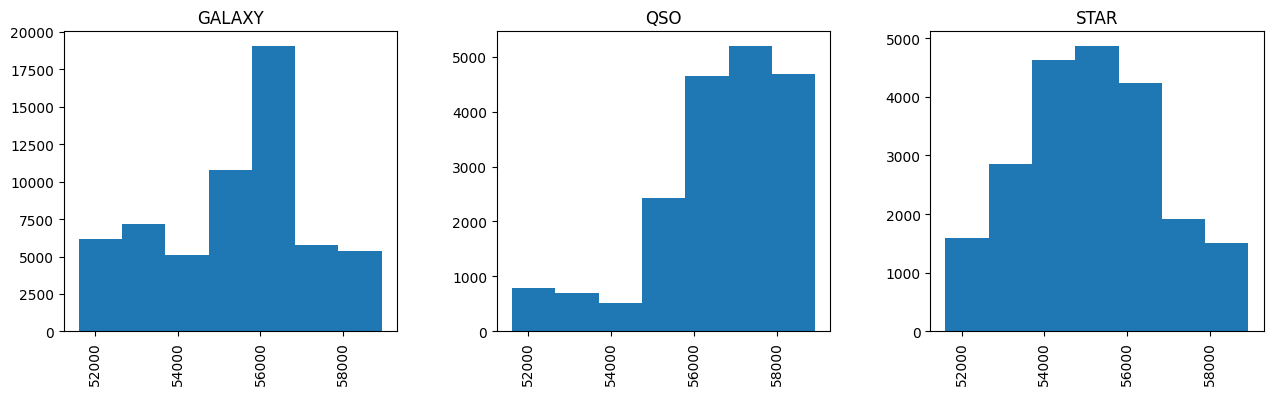

fiberid


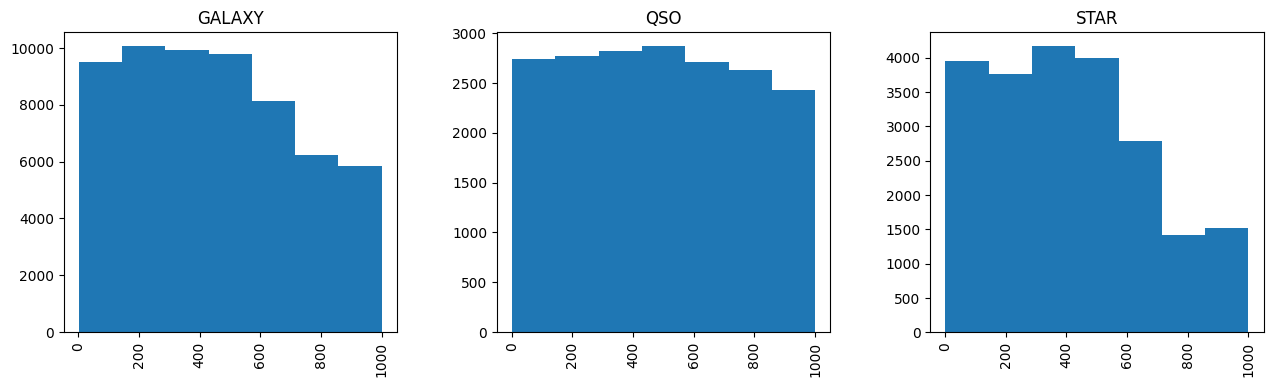

In [7]:
dfStars['last'] = 0
for att in dfStars.columns[:-1]:
    dfStars.hist(column=att, by='class', bins=7, figsize=(15,4), layout = (1,3)) # type: ignore
    print(att)
    plt.show()
dfStars.drop(['last'], axis=1, inplace=True)

<h1 style="font-weight: bold">CLASSIFICATION</h1>
I tried to perform 4 type of classificator: KNN, Decision Tree, Random Forest and Bayesian Classifier.<br>
For each classificator I check the performace cross-validation.
In each Iteration of the cross-validation I performe Feature Selection and the Rebalance with SMOTE with oversampling.

In [19]:
X = dfStars.drop(['class', 'rerun', 'objid'], axis=1)
y = dfStars['class']
X.shape, y.shape

((99999, 15), (99999,))

## Feature Selection
In the following I performe the features selection inside the 10-fold Cross-Validation, for mining the score of mutual information.<br>
In this way I can understand what feature are more correleted with the labeled-class, and using these attribute for the classification.

In [20]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

list_df = []
list_accuracy = []

dfKBest = pd.DataFrame()

k=0
for train, val in skf.split(X, y):
    # fit and predict using pipeline
    X_train = X.iloc[train, :]
    y_train = y.iloc[train]

    # Create an object SelectKBest with the value of k
    #selector = SelectKBest(score_func=f_classif, k=10)
    selector = SelectKBest(score_func=mutual_info_classif, k=10)

    # Fit
    X_selected = selector.fit_transform(X_train, y_train) # type: ignore
    # scores = np.round(selector.scores_, decimals=1)
    # dfKBest = pd.DataFrame(selector.scores_, columns=['Score']) # type: ignore
    dfKBest['Score'+str(k)] = selector.scores_
    k+=1

dfKBest.index = ['ra','dec','u','g','r','i','z','run','camcol','field','specobjid','redshift','plate','mjd','fiberid'] # type: ignore
display(dfKBest.sort_values(by='Score1', ascending=False))
    

Score0    Score1    Score2    Score3    Score4    Score5  \
redshift   0.801413  0.802067  0.802399  0.801870  0.801119  0.801476   
specobjid  0.301616  0.303163  0.303452  0.302159  0.299511  0.301469   
plate      0.276571  0.273548  0.275387  0.273765  0.272298  0.273823   
mjd        0.194075  0.191785  0.196564  0.192973  0.191960  0.194018   
z          0.144917  0.146345  0.147507  0.142748  0.143685  0.145364   
run        0.140316  0.143957  0.145214  0.143284  0.142886  0.143212   
g          0.121068  0.118965  0.118450  0.120795  0.118507  0.121056   
i          0.108462  0.109744  0.109489  0.106926  0.109264  0.111133   
u          0.100453  0.098457  0.100167  0.100356  0.100110  0.100898   
r          0.075705  0.075085  0.076310  0.075727  0.075650  0.074949   
fiberid    0.048202  0.046497  0.049707  0.045794  0.050325  0.050317   
dec        0.044417  0.045648  0.043449  0.044664  0.045292  0.044488   
ra         0.041151  0.040809  0.040861  0.038309  0.040295  0.039447   
camcol     0.001061  0.004674  0.006128  0.002180  0.000000  0.002617   
field      0.003064  0.000000  0.000380  0.004395  0.003692  0.003619   

             Score6    Score7    Score8    Score9  
redshift   0.802558  0.801741  0.801941  0.802269  
specobjid  0.304024  0.304186  0.301993  0.299970  
plate      0.275195  0.277378  0.274525  0.272823  
mjd        0.198566  0.192963  0.193084  0.193826  
z          0.144095  0.146003  0.145653  0.144756  
run        0.141986  0.143576  0.146320  0.139033  
g          0.120671  0.119555  0.119304  0.119186  
i          0.110834  0.110474  0.109794  0.110442  
u          0.103929  0.099421  0.099733  0.101456  
r          0.074254  0.076944  0.076334  0.074840  
fiberid    0.049348  0.051677  0.051564  0.046805  
dec        0.043683  0.044171  0.044553  0.043451  
ra         0.040704  0.041773  0.042767  0.038804  
camcol     0.001212  0.003681  0.002863  0.005914  
field      0.002146  0.006249  0.002898  0.005165

In [ ]:
row_means = dfKBest.mean(axis=1)
row_std = dfKBest.std(axis=1)
print(row_means.sort_values(ascending=False))


redshift     0.801881
specobjid    0.302137
plate        0.275442
mjd          0.193929
z            0.145102
run          0.143036
g            0.119672
i            0.109639
u            0.100497
r            0.075619
fiberid      0.048496
dec          0.044382
ra           0.040492
field        0.005348
camcol       0.002978
dtype: float64


I decide to drop the feature: fiberid, dec, ra, field and camcol, because they have a mutual information more near to 0 than 0.1

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

def cross_val_classif(clf, f1=True, fs=False, fold=10):
    
    pipe = imbpipeline(steps = [
        ['kBest', SelectKBest(score_func=mutual_info_classif, k=10)], 
        ['smote', SMOTE(random_state=42)], 
        ['classifier', clf]]
    )
    
    skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)

    if f1 == True:
        scoring = {
            'fscore': make_scorer(f1_score, average = 'macro'),
            'accuracy': make_scorer(accuracy_score)}
    else:
        scoring = {
            'accuracy': make_scorer(accuracy_score)}

    # Confusion Matrix
    y_pred = cross_val_predict(pipe, X, y, cv=skf, n_jobs=-1)
    conf_matrices = [confusion_matrix(y, y_pred)]

    results = cross_validate(
        pipe, 
        X, 
        y, 
        scoring=scoring, 
        cv=skf, 
        n_jobs=-1,
        return_estimator=True
    )
    
    results['conf_matrices'] = conf_matrices
    results['classification_report'] = classification_report(y, y_pred, target_names=['GALAXY', 'STAR', 'QSO'])


    selected_features = []
    for idx, estimator in enumerate(results['estimator']):
        mask = estimator.named_steps['kBest'].get_support()
        selected_features.append(list(X.columns[mask]))
        

    if fs == True:
        return results, selected_features
    else:
        return results

<h2>KNeighborsClassifier</h2>
I tried to perform KNN with 100 differents k, for understand which is the best. <br>
I decided to use the euclidean and the manhattan distance, for make a comparison

In [22]:
k_neighbors = 20
metrics = ['euclidean', 'manhattan']

accuracy_total = []
for k in range(1, k_neighbors+1, 1):
    accuracy_k = []
    for metric in metrics:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        score = cross_val_classif(knn, f1=False)
        accuracy_k.append(score['test_accuracy'].mean()) # type: ignore
    accuracy_total.append(accuracy_k)
        
accuracy_df = pd.DataFrame(np.array(accuracy_total), columns=metrics)
k_df = pd.DataFrame([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], columns=['k'])
accuracy_join= k_df.join(accuracy_df)

The following snip of code shows us the trend of the KNN's accuracy for the euclidean and manhattan distance.<br> 
The plot for each distance it's almost the same. But the accurasy reach just the 67% in the peak, for k = 3.

In [23]:
accuracy_join

k  euclidean  manhattan
0    1   0.619206   0.619496
1    2   0.676737   0.676787
2    3   0.655967   0.655977
3    4   0.670137   0.670227
4    5   0.659897   0.659947
5    6   0.669787   0.669847
6    7   0.660617   0.660677
7    8   0.666597   0.666607
8    9   0.659927   0.659937
9   10   0.661987   0.661977
10  11   0.658337   0.658357
11  12   0.659787   0.659787
12  13   0.656337   0.656347
13  14   0.656407   0.656407
14  15   0.653287   0.653297
15  16   0.653127   0.653137
16  17   0.651927   0.651927
17  18   0.651607   0.651617
18  19   0.648827   0.648827
19  20   0.648887   0.648907

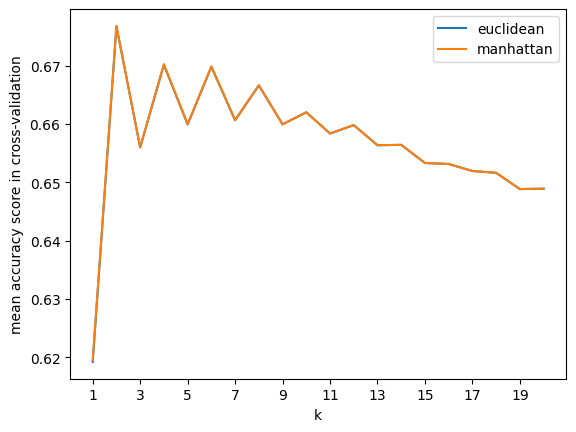

In [24]:
k_values = np.arange(1, 21)

# crea il grafico
plt.plot(k_values, accuracy_join['euclidean'], label='euclidean')
plt.plot(k_values, accuracy_join['manhattan'], label='manhattan')

# imposta le etichette dell'asse x
plt.xticks(np.arange(min(k_values), max(k_values)+1, 2.0))

plt.legend()
plt.xlabel('k')
plt.ylabel('mean accuracy score in cross-validation')
plt.show()

In [39]:
knn = KNeighborsClassifier(n_neighbors=2, metric='manhattan')
score, features = cross_val_classif(knn, fs=True)

print()
print('Accuracy')
print(score['test_accuracy'])
print('mean: ' + str(score['test_accuracy'].mean()))

print()
print('F1-score')
print(score['test_fscore'])
print('mean: ' + str(score['test_fscore'].mean()))


print()
print('Aggregate confusion matrix')
#agg_confusion_matrix = np.sum(score['conf_matrices'], axis=0)
#print(agg_confusion_matrix)
print(score['conf_matrices'][0])

print()
print('Classification Report')
print(score['classification_report'])

print()
print('Feature Selectione on each iteration')
for i in range(10):
    print(features[i])



Accuracy
[0.6825     0.6734     0.681      0.6749     0.6809     0.6753
 0.6719     0.674      0.6713     0.68266827]
mean: 0.6767868266826683

F1-score
[0.6001416  0.5903888  0.60143057 0.58994075 0.59904077 0.58841222
 0.58842433 0.58983441 0.58696757 0.6002244 ]
mean: 0.593480543069574

Aggregate confusion matrix
[[49045  7498  2902]
 [ 8716  8599  1646]
 [ 7399  4160 10034]]

Classification Report
              precision    recall  f1-score   support

      GALAXY       0.75      0.83      0.79     59445
        STAR       0.42      0.45      0.44     18961
         QSO       0.69      0.46      0.55     21593

    accuracy                           0.68     99999
   macro avg       0.62      0.58      0.59     99999
weighted avg       0.68      0.68      0.67     99999


Feature Selectione on each iteration
['u', 'g', 'r', 'i', 'z', 'run', 'specobjid', 'redshift', 'plate', 'mjd']
['u', 'g', 'r', 'i', 'z', 'run', 'specobjid', 'redshift', 'plate', 'mjd']
['u', 'g', 'r', 'i', 'z', '

<h2>Decision Tree</h2>

In [40]:
dtc = DecisionTreeClassifier()
score, features = cross_val_classif(dtc, fs=True)

print()
print('Accuracy')
print(score['test_accuracy'])
print('mean: ' + str(score['test_accuracy'].mean()))

print()
print('F1-score')
print(score['test_fscore'])
print('mean: ' + str(score['test_fscore'].mean()))


print()
print('Aggregate confusion matrix')
#agg_confusion_matrix = np.sum(score['conf_matrices'], axis=0)
#print(agg_confusion_matrix)
print(score['conf_matrices'][0])

print()
print('Classification Report')
print(score['classification_report'])

print()
print('Feature Selectione on each iteration')
for i in range(10):
    print(features[i])


Accuracy
[0.9627     0.9603     0.9621     0.962      0.9625     0.9602
 0.9604     0.9616     0.9596     0.96349635]
mean: 0.9614896349634965

F1-score
[0.95782262 0.95512317 0.95694111 0.95688529 0.95764992 0.95527591
 0.95491065 0.95661017 0.95426252 0.95868993]
mean: 0.9564171284058574

Aggregate confusion matrix
[[56944  2400   101]
 [ 1220 17738     3]
 [   83     1 21509]]

Classification Report
              precision    recall  f1-score   support

      GALAXY       0.98      0.96      0.97     59445
        STAR       0.88      0.94      0.91     18961
         QSO       1.00      1.00      1.00     21593

    accuracy                           0.96     99999
   macro avg       0.95      0.96      0.96     99999
weighted avg       0.96      0.96      0.96     99999


Feature Selectione on each iteration
['u', 'g', 'r', 'i', 'z', 'run', 'specobjid', 'redshift', 'plate', 'mjd']
['u', 'g', 'r', 'i', 'z', 'run', 'specobjid', 'redshift', 'plate', 'mjd']
['u', 'g', 'r', 'i', 'z', 

<h1>Random Forest</h1>

In [41]:
rfc = RandomForestClassifier()
score, features = cross_val_classif(rfc, fs=True)

print()
print('Accuracy')
print(score['test_accuracy'])
print('mean: ' + str(score['test_accuracy'].mean()))

print()
print('F1-score')
print(score['test_fscore'])
print('mean: ' + str(score['test_fscore'].mean()))


print()
print('Aggregate confusion matrix')
#agg_confusion_matrix = np.sum(score['conf_matrices'], axis=0)
#print(agg_confusion_matrix)
print(score['conf_matrices'][0])

print()
print('Classification Report')
print(score['classification_report'])

print()
print('Feature Selectione on each iteration')
for i in range(10):
    print(features[i])


Accuracy
[0.9775     0.9775     0.9782     0.9761     0.9796     0.9781
 0.9771     0.9778     0.9775     0.97979798]
mean: 0.9779197979797978

F1-score
[0.97409876 0.97407677 0.97482879 0.97250243 0.97652392 0.97476184
 0.97341395 0.97444188 0.97398517 0.97671792]
mean: 0.974535143073654

Aggregate confusion matrix
[[58281  1011   153]
 [ 1046 17912     3]
 [    5     0 21588]]

Classification Report
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     59445
        STAR       0.95      0.94      0.95     18961
         QSO       0.99      1.00      1.00     21593

    accuracy                           0.98     99999
   macro avg       0.97      0.97      0.97     99999
weighted avg       0.98      0.98      0.98     99999


Feature Selectione on each iteration
['u', 'g', 'r', 'i', 'z', 'run', 'specobjid', 'redshift', 'plate', 'mjd']
['u', 'g', 'r', 'i', 'z', 'run', 'specobjid', 'redshift', 'plate', 'mjd']
['u', 'g', 'r', 'i', 'z', '

<h2>Bayesian Classifier</h2>

In [42]:
byc = GaussianNB()
score, features = cross_val_classif(byc, fs=True)

print()
print('Accuracy')
print(score['test_accuracy'])
print('mean: ' + str(score['test_accuracy'].mean()))

print()
print('F1-score')
print(score['test_fscore'])
print('mean: ' + str(score['test_fscore'].mean()))


print()
print('Aggregate confusion matrix')
#agg_confusion_matrix = np.sum(score['conf_matrices'], axis=0)
#print(agg_confusion_matrix)
print(score['conf_matrices'][0])

print()
print('Classification Report')
print(score['classification_report'])

print()
print('Feature Selectione on each iteration')
for i in range(10):
    print(features[i])


Accuracy
[0.3031     0.3026     0.3015     0.3009     0.3066     0.299
 0.3047     0.2961     0.3031     0.29772977]
mean: 0.30153297729772977

F1-score
[0.29798734 0.29734587 0.29572805 0.29530792 0.30270451 0.2937965
 0.30082393 0.29046956 0.29920751 0.29233051]
mean: 0.2965701701610041

Aggregate confusion matrix
[[ 2321 22923 34201]
 [  657 12978  5326]
 [  523  6216 14854]]

Classification Report
              precision    recall  f1-score   support

      GALAXY       0.66      0.04      0.07     59445
        STAR       0.31      0.68      0.42     18961
         QSO       0.27      0.69      0.39     21593

    accuracy                           0.30     99999
   macro avg       0.41      0.47      0.30     99999
weighted avg       0.51      0.30      0.21     99999


Feature Selectione on each iteration
['u', 'g', 'r', 'i', 'z', 'run', 'specobjid', 'redshift', 'plate', 'mjd']
['u', 'g', 'r', 'i', 'z', 'run', 'specobjid', 'redshift', 'plate', 'mjd']
['u', 'g', 'r', 'i', 'z', '

<h1>Conclusion</h1>
<br>
The conclusion is that the best classifier for this problem is Random Forest, because have the best metrics in terms of Precision, Recall, Accuracy inside the Cross-Validation scores.

# Save The Model
<br>
I'll save the model of Random Forest in a file, for using them in an external application

In [43]:
X1 = X.drop(['fiberid', 'dec', 'ra', 'field', 'camcol'], axis=1)
sm = SMOTE(random_state=42)
X_fit, y_fit = sm.fit_resample(X1, y) # type: ignore

rfc.fit(X_fit, y_fit)

RandomForestClassifier()

In [44]:
with open('model.pkl', 'wb') as f:
    pickle.dump(rfc, f)